In [1]:
%load_ext autoreload

%autoreload 2

In [32]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog, BaseTileCatalog, TileCatalog
from bliss.surveys.dc2 import DC2DataModule
from case_studies.redshift.evaluation.utils.load_lsst import get_lsst_full_cat
from case_studies.redshift.evaluation.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.redshift.redshift_from_img.encoder.metrics import RedshiftMeanSquaredErrorBin

environ["BLISS_HOME"] = str(Path().resolve().parents[2])

output_dir = Path("/data/scratch/qiaozhih/DC2output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "/home/qiaozhih/bliss/case_studies/redshift/redshift_from_img/DC2_redshift_training/DC2_redshift_only_bin_allmetrics/checkpoints/encoder_0.133145.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_discrete_plot")

In [34]:
# set up testing dataset
dataset = instantiate(notebook_cfg.train.data_source)
dataset.setup("test")


In [35]:
dataset.test_dataset

In [36]:
len(dataset.test_dataset)

25000

In [37]:
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

### bliss using discrete varational dist

In [43]:
# Loop through the test set and update the metric
# load bliss trained model
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [48]:
bliss_discrete_output_path = output_dir / "bliss_output_discrete_large_split.pkl"
bliss_discrete_grid_output_path = output_dir / "bliss_output_discrete_grid_large_split.pkl"

if not bliss_discrete_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_mode_out_dict = bliss_encoder.mode_metrics.compute()
    bliss_discrete_out_dict = bliss_encoder.discrete_metrics.compute()

    with open(bliss_discrete_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_mode_out_dict, outp, pickle.HIGHEST_PROTOCOL)
    with open(bliss_discrete_grid_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_discrete_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_discrete_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)
    with open(bliss_discrete_grid_output_path, "rb") as inputp:
        bliss_discrete_out_dict = pickle.load(inputp)
    

100%|██████████| 6250/6250 [57:42<00:00,  1.80it/s] 


total num of pts: tensor([48418., 52167., 20791.,  6536.,  5932., 15768.], device='cuda:0')
total num of pts: tensor([24807., 47533., 41724., 20754.,  9656.,  4975.,   163.],
       device='cuda:0')
total num of pts: tensor([149612.], device='cuda:0')
total num of pts: tensor([19248.,  3034.,  8752., 11958., 34082., 72538.], device='cuda:0')
total num of pts: tensor([19250.,  3034.,  8754., 11962., 34087., 72563.], device='cuda:0')


NameError: name 'bliss_discrete_grid_output_path' is not defined

In [51]:
bliss_discrete_output_path = output_dir / "bliss_output_discrete_large_split.pkl"
bliss_discrete_grid_output_path = output_dir / "bliss_output_discrete_grid_large_split.pkl"
with open(bliss_discrete_output_path, "wb") as outp:  # Overwrites any existing file.
    pickle.dump(bliss_mode_out_dict, outp, pickle.HIGHEST_PROTOCOL)
with open(bliss_discrete_grid_output_path, "wb") as outp:  # Overwrites any existing file.
    pickle.dump(bliss_discrete_out_dict, outp, pickle.HIGHEST_PROTOCOL)

In [49]:
bliss_mode_out_dict = bliss_encoder.mode_metrics.compute()
bliss_discrete_out_dict = bliss_encoder.discrete_metrics.compute()

In [39]:
# batch = 0
# for batch_idx, x in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
#     batch = x
#     batch["images"] = batch["images"].to(device)
#     break

  0%|          | 0/6250 [00:01<?, ?it/s]


In [ ]:
bliss_discrete_out_dict = bliss_encoder.mode_metrics.compute()
bliss_discrete_grid_out_dict = bliss_encoder.discrete_metrics.compute()

In [52]:
bliss_output_path = output_dir / "bliss_output_large_split.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

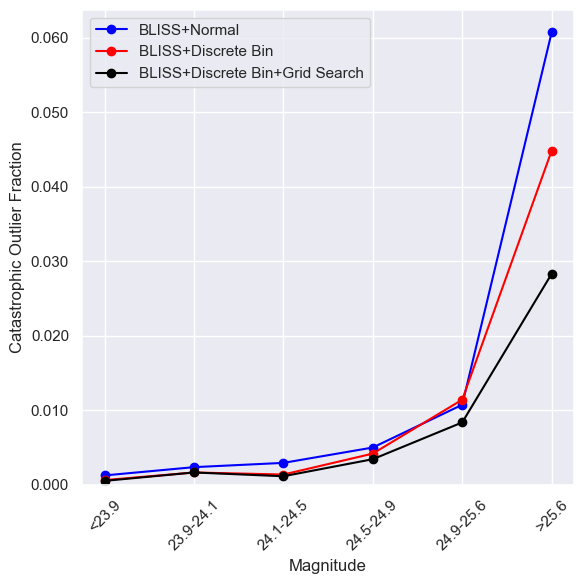

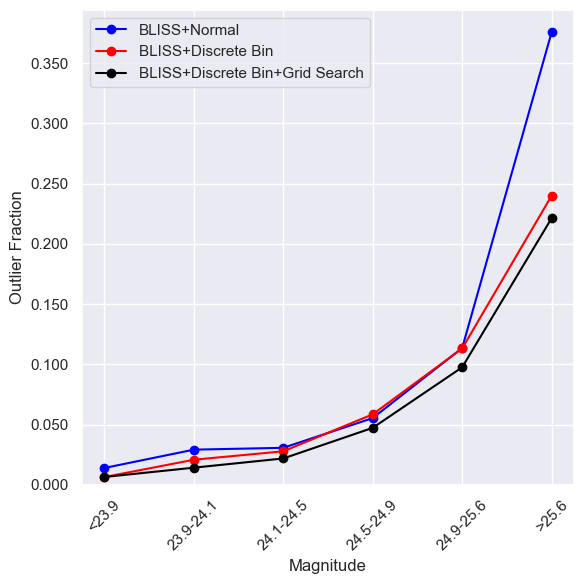

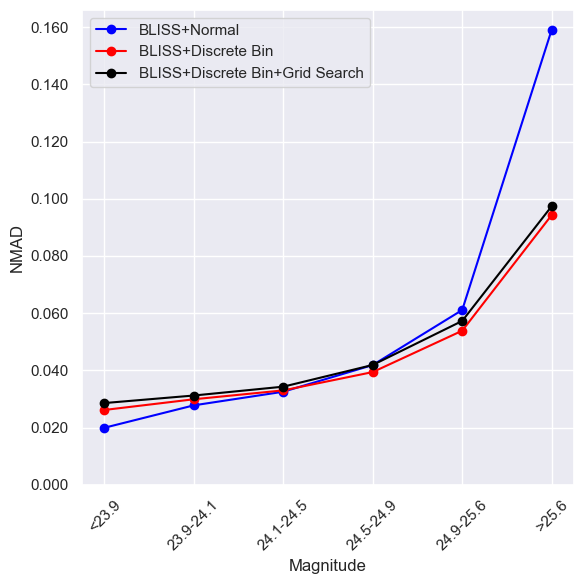

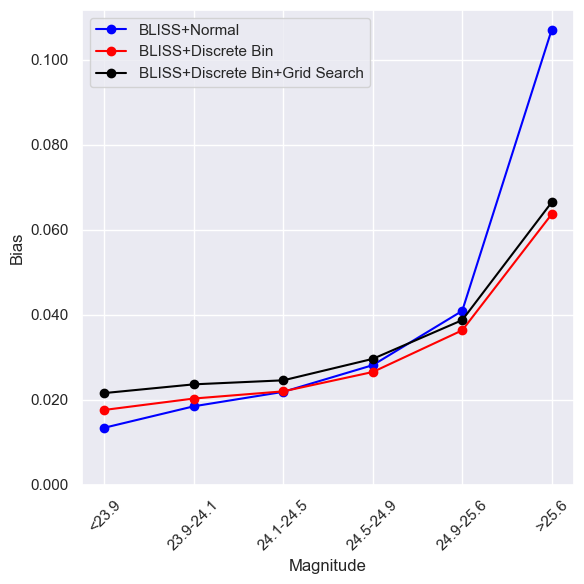

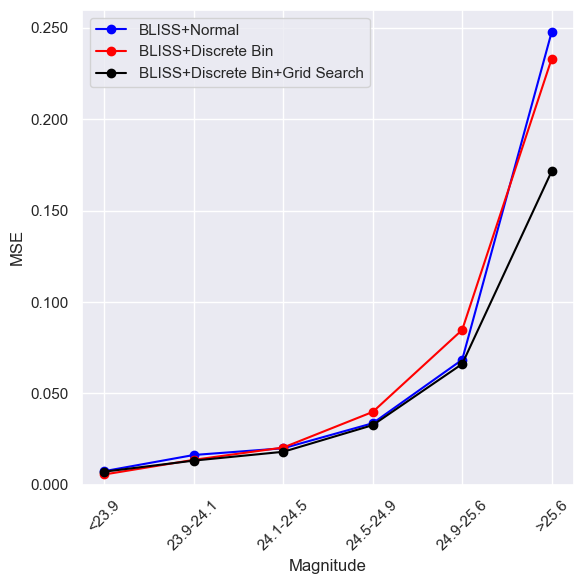

In [55]:
from matplotlib.ticker import FormatStrFormatter
metrics = ['outlier_fraction_cata', 'outlier_fraction', 'nmad', 'bias_abs', 'mse']
metric_labels = ['Catastrophic Outlier Fraction', 'Outlier Fraction', 'NMAD', 'Bias', 'MSE']
sns.set_theme()
for i, metric in enumerate(metrics):
    mag_ranges = ['<23.9', '23.9-24.1', '24.1-24.5', '24.5-24.9', '24.9-25.6', '>25.6']
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in reversed(range(6))]
    bliss_discrete = [bliss_mode_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(6)]
    bliss_discrete_grid = [bliss_discrete_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(6)]

    plt.figure(figsize=(6, 6))
    plt.plot(mag_ranges, bliss_values, label="BLISS+Normal", marker='o', c="blue")
    plt.plot(mag_ranges, bliss_discrete, label="BLISS+Discrete Bin", marker='o', c="red")
    plt.plot(mag_ranges, bliss_discrete_grid, label="BLISS+Discrete Bin+Grid Search", marker='o', c="black")
    plt.xlabel('Magnitude')
    plt.xticks(rotation=45)
    plt.ylabel(metric_labels[i])
    plt.ylim([0, None])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    # plt.savefig(os.path.join("/home/qiaozhih/bliss/case_studies/redshift/evaluation/plot",f'different_dist_Bliss.pdf'))

In [12]:
bliss_out_dict

{'redshifts/bias': -0.006504147779196501,
 'redshifts/bias_bin_0': -0.014045719988644123,
 'redshifts/bias_bin_1': -0.003189431270584464,
 'redshifts/bias_bin_2': -0.001660200534388423,
 'redshifts/bias_bin_3': -0.0022904197685420513,
 'redshifts/bias_bin_4': -0.0020288412924855947,
 'redshifts/bias_bin_5': -0.001150956959463656,
 'redshifts/mse': 0.1870339810848236,
 'redshifts/mse_bin_0': 0.24770021438598633,
 'redshifts/mse_bin_1': 0.06841427832841873,
 'redshifts/mse_bin_2': 0.03366375342011452,
 'redshifts/mse_bin_3': 0.01996874250471592,
 'redshifts/mse_bin_4': 0.016289599239826202,
 'redshifts/mse_bin_5': 0.007452603429555893,
 'redshifts/nmad': 0.1080448254942894,
 'redshifts/nmad_bin_0': 0.15906529128551483,
 'redshifts/nmad_bin_1': 0.06110619008541107,
 'redshifts/nmad_bin_2': 0.041873544454574585,
 'redshifts/nmad_bin_3': 0.032535992562770844,
 'redshifts/nmad_bin_4': 0.027776511386036873,
 'redshifts/nmad_bin_5': 0.019936883822083473,
 'redshifts/outlier_fraction': 0.285354